In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [2]:
tf.config.experimental.list_logical_devices()

2024-06-04 16:23:23.083454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-04 16:23:23.146098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-04 16:23:23.146336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-04 16:23:23.147398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
IMG_SIZE = 300
BATCH_SIZE = 16

# path_data = "./raw_data_dir/data-deon"
path_data = "./data-test"
# path_data = "./drive/MyDrive/EducaTour/data-test"


data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path_data,
    shuffle=True,
#     color_mode="grayscale",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

classes=data.class_names
print("Class names:", classes)

Found 1300 files belonging to 25 classes.
Class names: ['benteng_vredeburg', 'candi_borobudur', 'candi_prambanan', 'garuda_wisnu_kencana', 'gedung_sate', 'istana_maimun', 'jam_gadang', 'keong_mas', 'keraton_jogja', 'kota_tua', 'lawang_sewu', 'masjid_istiqlal', 'masjid_menara_kudus', 'masjid_raya_baiturrahman', 'menara_siger_lampung', 'monas', 'monumen_bandung_lautan_api', 'monumen_gong_perdamaian', 'monumen_nol_km', 'monumen_simpang_lima_gumul', 'patung_ikan_surabaya', 'patung_yesus_memberkati', 'tugu_jogja', 'tugu_khatulistiwa', 'tugu_pahlawan_surabaya']


# Image Processing

In [ ]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

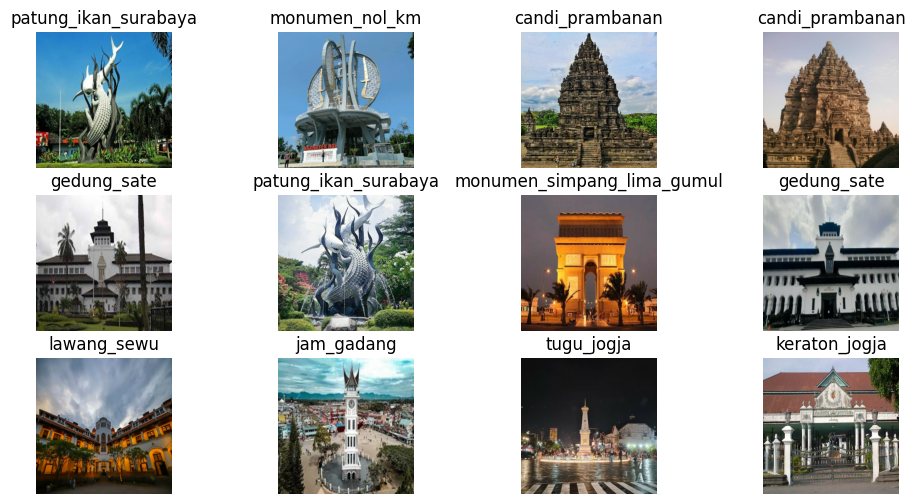

In [ ]:
plt.figure(figsize=(12, 6))
for img_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.title(f"{classes[label_batch[i]]}")
        plt.axis("Off")
        plt.imshow(img_batch[i].numpy().astype("int"), cmap='gray');

# Splitting Data

In [ ]:
len_data=len(data)

# Shuffle data
data=data.shuffle(buffer_size=10000, seed=42)

train_size=int(len_data*0.90)
# val_size=int(len_data*0.7)

train_data=data.take(train_size)
val_data=data.skip(train_size)
# test_data=data.skip(train_size).skip(val_size)

print(f"""Length of data in each batch
ori data: {len_data}
train data: {len(train_data)}
val data: {len(val_data)}
""")

Length of data in each batch
ori data: 82
train data: 73
val data: 9



# Augmenting Data

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0),
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.13),
])

# Creating Model

### Plotting Utility

In [ ]:
def plot_history(model_history, seq_1, seq_2):
    plt.plot(model_history.history[seq_1], label=seq_1)
    plt.plot(model_history.history[seq_2], label=seq_2)
    plt.legend()
    plt.title("training history");

## Model 1

In [ ]:
IMG_SHAPE=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)

model_1 = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(25, activation="softmax"),
], name="model_1")

In [ ]:
model_1.build(input_shape=IMG_SHAPE)
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 300, 300, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 298, 298, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (16, 149, 149, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 147, 147, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 73, 73, 64)          0         
 g2D)                                                      

In [ ]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
%%time
history_1 = model_1.fit(
    train_data,
    epochs=50,
    verbose=1,
    validation_data=val_data,
)

Epoch 1/50


2024-06-02 10:32:21.137012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


73/73 [==============================] - 19s 170ms/step - loss: 3.2181 - accuracy: 0.0424 - val_loss: 3.1172 - val_accuracy: 0.1319
Epoch 2/50
73/73 [==============================] - 13s 152ms/step - loss: 3.0183 - accuracy: 0.1107 - val_loss: 2.8118 - val_accuracy: 0.1806
Epoch 3/50
73/73 [==============================] - 13s 151ms/step - loss: 2.7925 - accuracy: 0.1825 - val_loss: 2.3606 - val_accuracy: 0.2292
Epoch 4/50
73/73 [==============================] - 13s 152ms/step - loss: 2.4801 - accuracy: 0.2457 - val_loss: 2.2720 - val_accuracy: 0.3333
Epoch 5/50
73/73 [==============================] - 13s 153ms/step - loss: 2.3045 - accuracy: 0.3166 - val_loss: 2.2144 - val_accuracy: 0.3542
Epoch 6/50
73/73 [==============================] - 13s 153ms/step - loss: 2.0666 - accuracy: 0.3867 - val_loss: 1.8267 - val_accuracy: 0.4097
Epoch 7/50
73/73 [==============================] - 13s 153ms/step - loss: 1.9410 - accuracy: 0.4377 - val_loss: 1.6818 - val_accuracy: 0.5069
Epoch 8/50

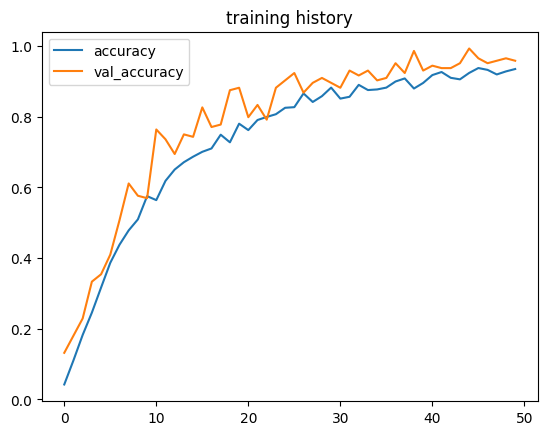

In [ ]:
plot_history(history_1, "accuracy", "val_accuracy")

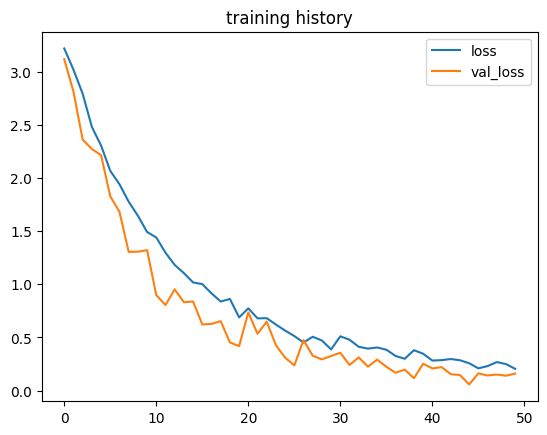

In [ ]:
plot_history(history_1, "loss", "val_loss")

In [ ]:
model_1.save("history/model_1.h5")

## Model 2
Using InceptionV3

### Split dir to train and val

In [ ]:
import os
import shutil
import random

source_p = "./data-test/"
dest_p = "./tmp/"
split_dir = ["training", "validation"]
split_size = 0.9

LABELS = sorted(
    [
        "monas", "kota_tua", "gedung_sate", "candi_borobudur", "candi_prambanan", "lawang_sewu", "keraton_jogja",
        "monumen_bandung_lautan_api", "benteng_vredeburg", "jam_gadang", "patung_ikan_surabaya", "tugu_jogja",
        "garuda_wisnu_kencana", "masjid_raya_baiturrahman", "masjid_istiqlal", "monumen_nol_km", "tugu_khatulistiwa",
        "monumen_simpang_lima_gumul", "menara_siger_lampung", "istana_maimun", "patung_yesus_memberkati", "tugu_pahlawan_surabaya",
        "keong_mas", "monumen_gong_perdamaian", "masjid_menara_kudus"
    ])

# def split_to_train_val_dir(dest_dir, source_dir, labels, train_dir, val_dir, split_size):

#     for d in ["training","validation"]:
#         for sd in labels:
#             os.makedirs(os.path.join(dest_dir, d, sd))

#     list_dir = os.listdir(source_dir)
#     shuffled_data = random.sample(list_dir, len(list_dir))

sts=True
list_source_p = sorted(os.listdir(source_p))
while sts:
    try:
        for d in split_dir:
            for sd in LABELS:
                os.makedirs(os.path.join(dest_p, d, sd))
        sts=False
    except FileExistsError:
        shutil.rmtree(dest_p)

for i, d in enumerate(list_source_p):
    p = os.path.join(source_p, d)
#     print("###### data", LABELS[i])
    for y, sd in enumerate(os.listdir(p)):
        len_f = int(len(os.listdir(p)) * split_size)
        p_source = os.path.join(p, sd)

        if y < len_f:
            nye = split_dir[0] #training
        else:
            nye = split_dir[1] #validation

        p_dest = os.path.join(dest_p, nye, LABELS[i], sd)
        shutil.copyfile(p_source, p_dest)

### Creating model_2 Architecture

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [ ]:
input_tensor = tf.keras.Input(shape=(300,300,3))

base_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights="imagenet")

for layer in base_model.layers[:151]:
    layer.trainable = False

for i, l in enumerate(base_model.layers):
    print(i, l.name, l.trainable)

0 input_11 False
1 conv2d_940 False
2 batch_normalization_940 False
3 activation_940 False
4 conv2d_941 False
5 batch_normalization_941 False
6 activation_941 False
7 conv2d_942 False
8 batch_normalization_942 False
9 activation_942 False
10 max_pooling2d_40 False
11 conv2d_943 False
12 batch_normalization_943 False
13 activation_943 False
14 conv2d_944 False
15 batch_normalization_944 False
16 activation_944 False
17 max_pooling2d_41 False
18 conv2d_948 False
19 batch_normalization_948 False
20 activation_948 False
21 conv2d_946 False
22 conv2d_949 False
23 batch_normalization_946 False
24 batch_normalization_949 False
25 activation_946 False
26 activation_949 False
27 average_pooling2d_90 False
28 conv2d_945 False
29 conv2d_947 False
30 conv2d_950 False
31 conv2d_951 False
32 batch_normalization_945 False
33 batch_normalization_947 False
34 batch_normalization_950 False
35 batch_normalization_951 False
36 activation_945 False
37 activation_947 False
38 activation_950 False
39 activat

In [ ]:
model_2_inp = base_model.input
model_2_inp

<KerasTensor: shape=(None, 300, 300, 3) dtype=float32 (created by layer 'input_11')>

In [ ]:
last_output = base_model.get_layer("mixed7").output
last_output

<KerasTensor: shape=(None, 17, 17, 768) dtype=float32 (created by layer 'mixed7')>

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(25, activation="softmax")(x)

model_2 = Model(inputs=input_tensor, outputs=x, name="model_2")
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d_940 (Conv2D)         (None, 149, 149, 32)         864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_940 (B  (None, 149, 149, 32)         96        ['conv2d_940[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_940 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_94

In [ ]:
model_2.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

### Prepare Data and Train

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# train_dir = "./drive/MyDrive/EducaTour/tmp/training"
# val_dir = "./drive/MyDrive/EducaTour/tmp/validation"

train_dir = "./tmp/training"
val_dir = "./tmp/validation"

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=10,
                                #    width_shift_range=0.2,
                                #    height_shift_range=0.2,
                                #    shear_range=0.2,
                                #    zoom_range=0.2,
                                   fill_mode="nearest",
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=16,
    class_mode="categorical",
    target_size=(300, 300)
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    batch_size=16,
    class_mode="categorical",
    target_size=(300, 300)
)

Found 1150 images belonging to 25 classes.
Found 150 images belonging to 25 classes.


In [ ]:
%%time
# Train the model.
history_2 = model_2.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 12,
    verbose = 1
)

Epoch 1/12
72/72 [==============================] - 35s 404ms/step - loss: 2.7718 - accuracy: 0.1826 - val_loss: 1.2160 - val_accuracy: 0.6533
Epoch 2/12
72/72 [==============================] - 29s 401ms/step - loss: 1.1525 - accuracy: 0.6783 - val_loss: 0.2340 - val_accuracy: 0.9467
Epoch 3/12
72/72 [==============================] - 29s 399ms/step - loss: 0.4441 - accuracy: 0.8730 - val_loss: 0.1411 - val_accuracy: 0.9667
Epoch 4/12
72/72 [==============================] - 29s 400ms/step - loss: 0.1880 - accuracy: 0.9400 - val_loss: 0.0390 - val_accuracy: 0.9933
Epoch 5/12
72/72 [==============================] - 29s 399ms/step - loss: 0.1289 - accuracy: 0.9696 - val_loss: 0.0250 - val_accuracy: 0.9867
Epoch 6/12
72/72 [==============================] - 29s 400ms/step - loss: 0.0987 - accuracy: 0.9696 - val_loss: 0.0503 - val_accuracy: 0.9933
Epoch 7/12
72/72 [==============================] - 29s 397ms/step - loss: 0.0657 - accuracy: 0.9852 - val_loss: 0.0292 - val_accuracy: 0.9933

### Save Model

In [ ]:
gdrive="drive/MyDrive/EducaTour/"
model_2.save(gdrive+"history/model_2_inceptionv3.h5")
model_2.save(gdrive+"history/model_2_inceptionv3.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Plot History

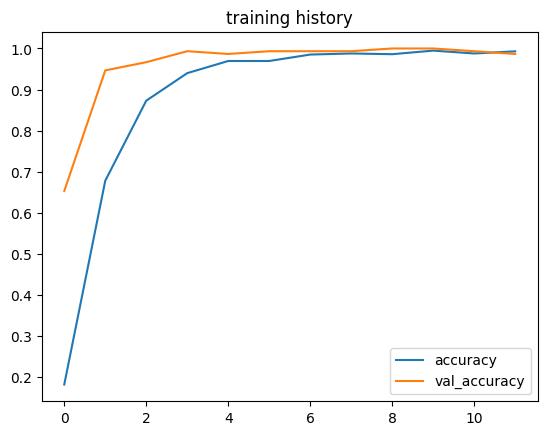

In [ ]:
plot_history(model_history=history_2, seq_1="accuracy", seq_2="val_accuracy")

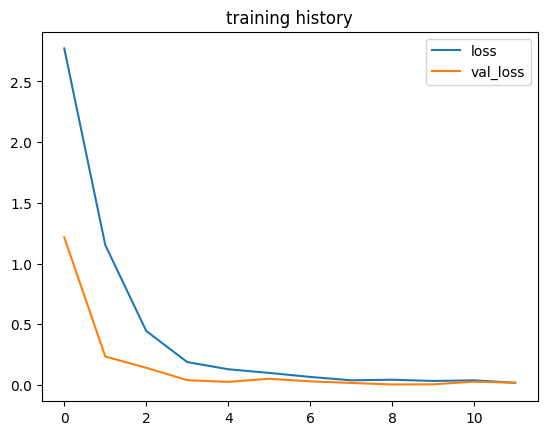

In [ ]:
plot_history(model_history=history_2, seq_1="loss", seq_2="val_loss")

# Testing Model

## Utils

In [11]:
LABELS = sorted(
    [
        "monas", "kota_tua", "gedung_sate", "candi_borobudur", "candi_prambanan", "lawang_sewu", "keraton_jogja",
        "monumen_bandung_lautan_api", "benteng_vredeburg", "jam_gadang", "patung_ikan_surabaya", "tugu_jogja",
        "garuda_wisnu_kencana", "masjid_raya_baiturrahman", "masjid_istiqlal", "monumen_nol_km", "tugu_khatulistiwa",
        "monumen_simpang_lima_gumul", "menara_siger_lampung", "istana_maimun", "patung_yesus_memberkati", "tugu_pahlawan_surabaya",
        "keong_mas", "monumen_gong_perdamaian", "masjid_menara_kudus"
    ])

for i, c in enumerate(LABELS):
    print(i, c)

0 benteng_vredeburg
1 candi_borobudur
2 candi_prambanan
3 garuda_wisnu_kencana
4 gedung_sate
5 istana_maimun
6 jam_gadang
7 keong_mas
8 keraton_jogja
9 kota_tua
10 lawang_sewu
11 masjid_istiqlal
12 masjid_menara_kudus
13 masjid_raya_baiturrahman
14 menara_siger_lampung
15 monas
16 monumen_bandung_lautan_api
17 monumen_gong_perdamaian
18 monumen_nol_km
19 monumen_simpang_lima_gumul
20 patung_ikan_surabaya
21 patung_yesus_memberkati
22 tugu_jogja
23 tugu_khatulistiwa
24 tugu_pahlawan_surabaya


In [12]:
import os

def load_model(fpath, optimizer=None, loss=None, isCompile=False):
    
    model = tf.keras.models.load_model(fpath, compile=isCompile)
    
    if not isCompile:
        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=["accuracy"]
        )
    
    return model

# Preprocess Data
def preprocess_img(img, width, height):
    img = tf.io.read_file(img)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, (width, height))    
    return img

# Predicting class
def predict_img(img, model):
    img = preprocess_img(img)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_cat = pred_prob.argmax(axis=-1)
    pred_class = LABELS[pred_cat[0]]
    
    plt.imshow(img/255.0)
    plt.title(f"Pred: {pred_prob.max()*100:.2f}% {pred_class}")
    plt.axis(False)
    plt.show()

## Load Model 1

In [13]:
load_model_1 = load_model(
    fpath="./history/model_1.h5",
#     optimizer=tf.keras.optimizers.RMSprop(1e-4),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
    isCompile=True,
)

load_model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                       

1/1 [==============================] - 0s 54ms/step


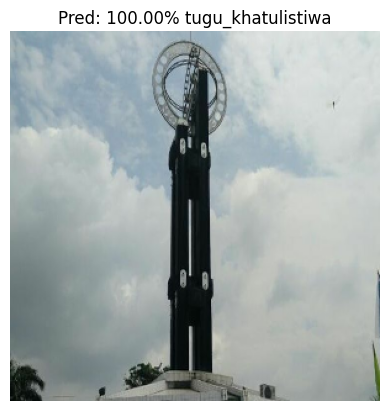

1/1 [==============================] - 0s 15ms/step


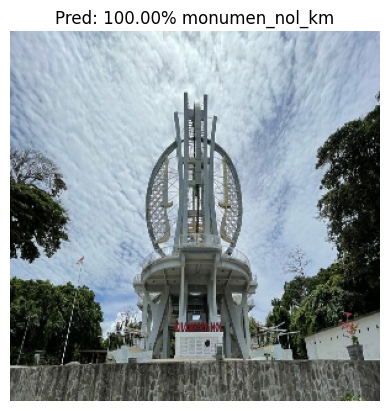

1/1 [==============================] - 0s 15ms/step


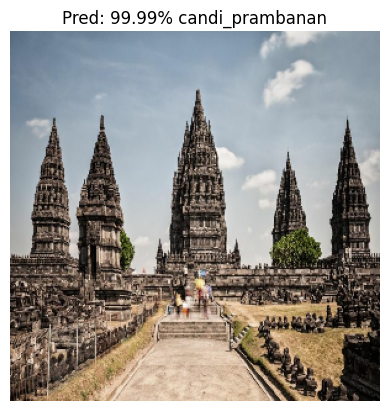

1/1 [==============================] - 0s 12ms/step


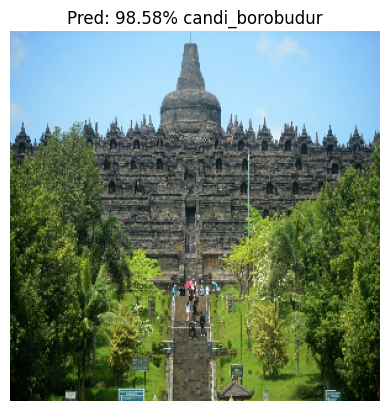

1/1 [==============================] - 0s 14ms/step


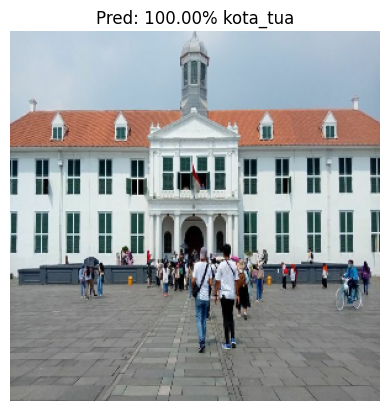

1/1 [==============================] - 0s 13ms/step


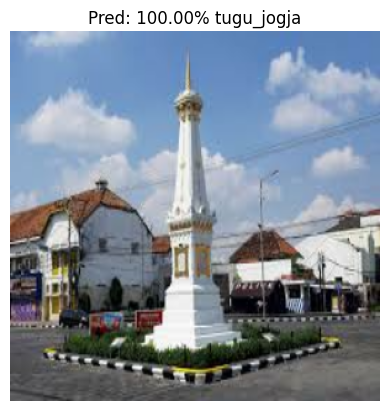

1/1 [==============================] - 0s 13ms/step


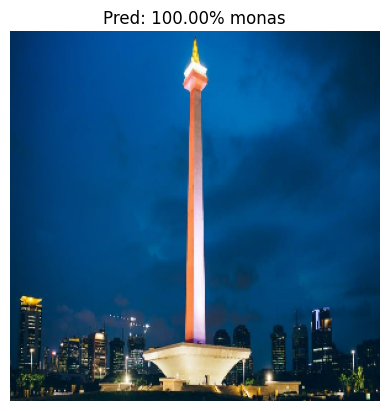

1/1 [==============================] - 0s 12ms/step


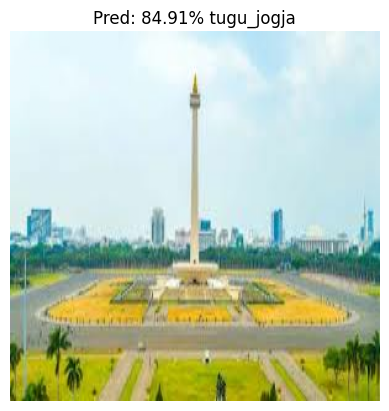

In [16]:
list_new_img = os.listdir("./data-predict-on-new-img/")

for x in list_new_img:
    predict_img(os.path.join("./data-predict-on-new-img", x), load_model_1)

## Load Model 2 (InceptionV3)

In [14]:
load_model_2 = load_model(
    fpath="./history/model_2_inceptionv3.h5",
    optimizer=tf.keras.optimizers.RMSprop(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    isCompile=False,
)

load_model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_940 (Conv2D)            (None, 149, 149, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_940 (Batch  (None, 149, 149, 32  96         ['conv2d_940[0][0]']             
 Normalization)                 )                                                           

 conv2d_951 (Conv2D)            (None, 35, 35, 32)   6144        ['average_pooling2d_90[0][0]']   
                                                                                                  
 batch_normalization_945 (Batch  (None, 35, 35, 64)  192         ['conv2d_945[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_947 (Batch  (None, 35, 35, 64)  192         ['conv2d_947[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_950 (Batch  (None, 35, 35, 96)  288         ['conv2d_950[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_962 (Conv2D)            (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_962 (Batch  (None, 35, 35, 64)  192         ['conv2d_962[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_962 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_962[0][0]']
                                                                                                  
 conv2d_960 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_96

                                                                                                  
 activation_969 (Activation)    (None, 17, 17, 96)   0           ['batch_normalization_969[0][0]']
                                                                                                  
 max_pooling2d_42 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_966[0][0]',         
                                                                  'activation_969[0][0]',         
                                                                  'max_pooling2d_42[0][0]']       
                                                                                                  
 conv2d_97

 mixed4 (Concatenate)           (None, 17, 17, 768)  0           ['activation_970[0][0]',         
                                                                  'activation_973[0][0]',         
                                                                  'activation_978[0][0]',         
                                                                  'activation_979[0][0]']         
                                                                                                  
 conv2d_984 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_984 (Batch  (None, 17, 17, 160)  480        ['conv2d_984[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_994 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_994 (Batch  (None, 17, 17, 160)  480        ['conv2d_994[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_994 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_994[0][0]']
                                                                                                  
 conv2d_995 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_994[0][0]']         
                                                                                                  
 batch_normalization_995 (Batch  (None, 17, 17, 160)  480        ['conv2d_995[0][0]']             
 Normaliza

 activation_1004 (Activation)   (None, 17, 17, 192)  0           ['batch_normalization_1004[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_1005 (Conv2D)           (None, 17, 17, 192)  258048      ['activation_1004[0][0]']        
                                                                                                  
 batch_normalization_1005 (Batc  (None, 17, 17, 192)  576        ['conv2d_1005[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_1005 (Activation)   (None, 17, 17, 192)  0           ['batch_normalization_1005[0][0]'
                                                                 ]                                
          

 flatten_10 (Flatten)           (None, 221952)       0           ['mixed7[0][0]']                 
                                                                                                  
 dense_20 (Dense)               (None, 64)           14204992    ['flatten_10[0][0]']             
                                                                                                  
 dropout_10 (Dropout)           (None, 64)           0           ['dense_20[0][0]']               
                                                                                                  
 dense_21 (Dense)               (None, 25)           1625        ['dropout_10[0][0]']             
                                                                                                  
Total params: 23,181,881
Trainable params: 18,761,689
Non-trainable params: 4,420,192
__________________________________________________________________________________________________
